# Homework 2

Covers Lectures [4](../lectures/lec_04.ipynb), [5](../lectures/lec_05.ipynb), [6](../lectures/lec_06.ipynb), [7](../lectures/lec_07.ipynb) and [8](../lectures/lec_08.ipynb).

Consider the steady state heat equation on a heterogeneous rod with no heat sources:
$$
\frac{d}{dx}\left(c(x)\frac{d}{dx}T(x)\right) = 0,
$$
and boundary values:
$$
T(0) = 1\;\mbox{and}\;T(1) = 0.
$$

We are interested in cases in which we are uncertain about the conductivity, $c(x)$.
Before we proceed, we need to put together all our prior beliefs and come up with a stochastic model for $c(x)$ that represents our uncertainty.
This requires assigning a probability measure on a function space (the subject of [Lecture 9](../lectures/lec_09.ipynb)).
For now, we will just give you a model.
We will model $c = c(x;\boldsymbol{\xi})$ as:
$$
c(x;\boldsymbol{\xi}) = c_0(x)\exp\{g(x;\boldsymbol{\xi})\},
$$
where $k_0(x)$ is a "mean" conductivity level and $g(x;\boldsymbol{\xi})$ is a random field.
The reason for the exponential is that $k(x;\boldsymbol{x})$ must be positive.
Assume that $g(x;\boldsymbol{\xi})$ has the following form:
$$
g(x;\boldsymbol{\xi}) = \sum_{i=1}^\infty\xi_i\phi_i(x),
$$
where $\phi_i(x)$ are functions of $x$ and $\xi_i$ are independent standard normal random variables with zero mean and unit variance.
For this particular example, we will assume that:
$$
\phi_i(x) = \frac{\sqrt{2}\sigma}{(i - \frac{1}{2})\pi}\sin\left((i-\frac{1}{2})\pi x\right),
$$
where $\sigma>0$ is a parameter controlling the variance of the random field.
For the record, this corresponds to a random field known as the [Wiener-Lévy process](https://en.wikipedia.org/wiki/Wiener_process).
Since, we cannot actually work with the infinite sums, let's truncate at $i=d$ and define:
$$
g_d(x;\boldsymbol{\xi}) = \sum_{i=1}^d\xi_i\phi_i(x).
$$
Let's implement the field:

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# This computes the random field given a xi
def g(x, xi, sigma=1.):
    """
    Arguments:
    x     -   One dimensional vector containing the points at which you wish to evaluate the field.
    xi    -   One dimensional vector of the random variables. The dimensionality of this vector
              corresponds to the ``d`` in the math above.
    sigma -   This is the variance of the field.
    """
    res = np.zeros(x.shape[0])
    d = xi.shape[0]
    for i in xrange(d):
        res += xi[i] * math.sqrt(2) * sigma / (i - .5) / math.pi * np.sin((i - .5) * math.pi * x)
    return res

Here are some samples to visualize $g(x,\boldsymbol{\xi})$.

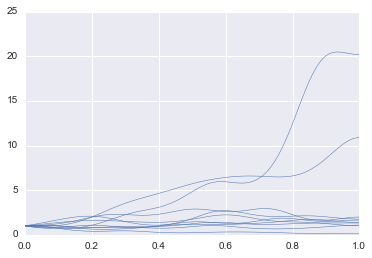

In [2]:
# Take some samples now
x = np.linspace(0, 1, 100)
d = 10
fig, ax = plt.subplots()
for i in xrange(10):
    xi = np.random.randn(d)
    ax.plot(x, np.exp(g(x, xi)), color=sns.color_palette()[0], linewidth=0.5)
plt.show()

In the above example, we just used $10$ $\xi$'s. Let's see what happens when we use 50:

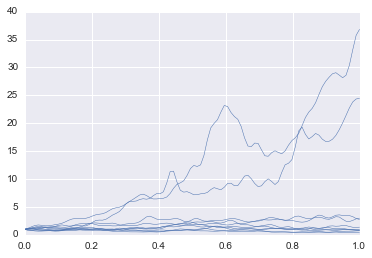

In [3]:
d = 50
fig, ax = plt.subplots()
for i in xrange(10):
    xi = np.random.randn(d)
    ax.plot(x, np.exp(g(x, xi)), color=sns.color_palette()[0], linewidth=0.5)
plt.show()

You can experiment with higher numbers and you will start seeing more and more fine structure.
The Weiner-Lévy process exhibits the self-similarity behavior of fractals.
If you zoom in, you will start seeing repetitions of itsself. That's of course, for the limit of taking $d\rightarrow\infty$.

This was a little bit off topic. However, let's return to our stochastic boundary value problem.
We need to create a solver. We will develop a solver based on the [finite volume method](https://en.wikipedia.org/wiki/Finite_volume_method) using [FiPy](http://www.ctcms.nist.gov/fipy).
You have to install the following packages:
```
pip install ez_setup
pip install fipy
```
Here is the solver:

In [4]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    nx          -    Number of grid points
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, nx=100, value_left=1., value_right=0.):
        self.nx = nx
        self.dx = 1. / nx
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        self.eq = fipy.DiffusionTerm(coeff=self.C)
        
    def __call__(self, xi):
        """
        Evaluates the code at a specific xi.
        """
        x = self.mesh.faceCenters.value.flatten()
        g_val = g(x, xi)
        self.C.setValue(np.exp(g_val))
        self.eq.solve(var=self.phi)
        return self.phi.value.flatten()

As before, notice that we have made the solver work just like a function of $\boldsymbol{\xi}$.
Here are a few evaluations:

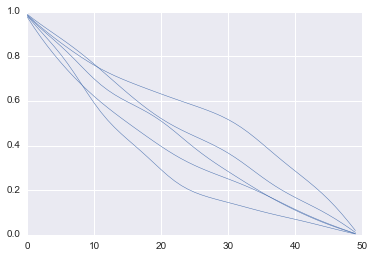

In [5]:
solver = SteadyStateHeat1DSolver(nx=50)
for i in xrange(5):
    xi = np.random.randn(10)
    y = solver(xi)
    plt.plot(y, color=sns.color_palette()[0], linewidth=0.5)

If you want, you can try increasing the dimensionality of $\boldsymbol{\xi}$:

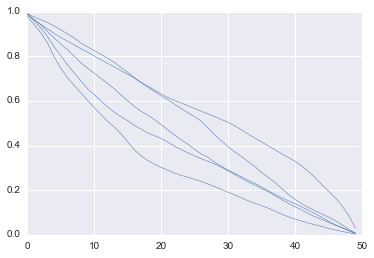

In [6]:
solver = SteadyStateHeat1DSolver(nx=50)
for i in xrange(5):
    xi = np.random.randn(100)
    y = solver(xi)
    plt.plot(y, color=sns.color_palette()[0], linewidth=0.5)

You will notice that the even though the samples from $g(x)$ become more and more wavy, samples from the forward model do not become more wavy. This is because of the *smoothing effects* of the elliptic operator. But this is also off topic.

In the problems below, you will have to propagate uncertainty through the model using a variety of methods and compare them to each other. To establish the ground truth for the statistics, you need to do a thorough MC sampling.

In [ ]:
def mc_sample(num_samples, solver, dim=10):
    y = np.zeros(solver.nx)
    y2 = np.zeros(solver.nx)
    for i in xrange(num_samples):
        if i % 100 == 0:
            print 'sample ', i + 1, 'out of', num_samples
        xi = np.random.randn(dim)
        ys = solver(xi)
        y += ys
        y2 += ys ** 2
    y_m = y / num_samples
    y_v = y2 / num_samples - y_m ** 2
    return y_m, y_v

In [ ]:
y_m, y_v = mc_sample(10000, solver)

sample  1 out of 10000
sample  101 out of 10000
sample  201 out of 10000
sample  301 out of 10000
sample  401 out of 10000
sample  501 out of 10000
sample  601 out of 10000
sample  701 out of 10000
sample  801 out of 10000
sample  901 out of 10000
sample  1001 out of 10000
sample  1101 out of 10000
sample  1201 out of 10000
sample  1301 out of 10000
sample  1401 out of 10000
sample  1501 out of 10000
sample  1601 out of 10000
sample  1701 out of 10000
sample  1801 out of 10000
sample  1901 out of 10000
sample  2001 out of 10000
sample  2101 out of 10000
sample  2201 out of 10000
sample  2301 out of 10000
sample  2401 out of 10000
sample  2501 out of 10000
sample  2601 out of 10000
sample  2701 out of 10000
sample  2801 out of 10000
sample  2901 out of 10000
sample  3001 out of 10000
sample  3101 out of 10000
sample  3201 out of 10000
sample  3301 out of 10000
sample  3401 out of 10000
sample  3501 out of 10000
sample  3601 out of 10000
sample  3701 out of 10000
sample  3801 out of 1000

In [ ]:
fig, ax = plt.subplots()
x = solver.mesh.cellCenters.value.flatten()
ax.plot(x, y_m)
y_s = np.sqrt(y_v)
y_l = y_m - 2. * y_s
y_u = y_m + 2. * y_s
ax.fill_between(x, y_l, y_u, alpha=0.25)

Please answer the following questions:

## Problems 
1. Assume d=2 and represent $c(x;\boldsymbol{\xi})$ as a function of x and $\xi_i$, i=1,2. The code in the lecture notes will be helpful for completing this problem.
    
    a. Estalish the ground truth on the mean and variance of $y(x;\boldsymbol{\xi})$ by taking 100,000 Monte Carlo samples.
    
    b. Propagate uncertainty through the model using 10, 100, 1,000, and 1,0000 MC samples and plot the L2 error in the estimation of the mean and the variance.
    
    c. Repeat b. 100 times to get the uncertainty induced by the fact that MC estimates are noisy. You can use the function [numpy.percentile](http://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html) to get lower and upper uncertainty bars for the evolution of the L2 error.
    
    d. Do the same as b. using Latin Hypercube sampling.
    
    e. Do the same as c. for d.
    
    f. Put the evolution of the L2 errors with the uncertainty bars for MC and Latin Hyper cube in the same plot. Which one is better?

2. Solve the problem using the stochastic collocation method using Hermite polynomials of order $N=2$ and $5$ and compare the mean and the variance to the ground truth established in 1.a. 

3. (optional) Solve the problem using the stochastic Galerkin method using Hermite polynomials of order $N=2$ and $5$ and compare the mean and the variance to the ground truth established in 1.a. (optional bonus problem)

## Hints
To build the 2D Hermite polynomials you can use [py-orthpol](https://github.com/PredictiveScienceLab/py-orthpol):

In [ ]:
import scipy.stats
from scipy.stats import norm
import orthpol
p = orthpol.ProductBasis(degree=2, rvs=[norm(), norm()])
print str(p)
# Which can be used as a function:
print p(np.random.randn(1, 2)) # But be careful, because it requires arrays to be 2D (rows correspond to samples and columns to dimensions)

In case you need a suitable quadrature rule in 2D, you can use [py-design](https://github.com/PredictiveScienceLab/py-design) to obtain it. For example, the Gauss-Hermite sparse grid quadrature:

In [ ]:
import design
X, w = design.sparse_grid(num_dim=2, max_level=3, rule='GH')
plt.plot(X[:, 0], X[:, 1], '.', markersize=10)